# 量子 k 均值聚类

Dynex 是世界上唯一可访问的神经拟态量子计算云，用于大规模解决现实问题。此示例演示了如何使用 Dynex SDK 使用 Pyton 在 Dynex 平台上使用 Python 进行计算。

In [19]:
import dynex
import dimod
from sklearn.datasets import make_blobs
from collections import defaultdict
import matplotlib.pyplot as plt
import math
import dwavebinarycsp #pip install dwavebinarycsp

使用 Dynex 平台识别数据集中的簇的演示。

在处理大型数据集时，我们并不总是拥有整齐标记的数据（即大多数（如果不是全部）数据可能是未标记的）。然而，一切并没有丢失，因为我们仍然可以通过聚类从这些数据中提取见解。

例如，在处理住房数据（即平方英尺和价格）时，我们可以识别该数据中可能指示不同社区的集群。另一个例子可能是拥有消费者观看的电视节目的布尔向量；这些数据中的集群可以帮助识别特定的消费者群体。

同样，如果我们的数据集中确实有一些标记的数据点，我们可能会根据这些标记整个集群。

## 支持功能

In [24]:
def get_groupings(sample):
    """抓取选定的项目并按颜色对它们进行分组"""
    colored_points = defaultdict(list)

    for label, bool_val in sample.items():
        # 跳过未选择的项目
        if not bool_val:
            continue

        # 解析所选项目
        # 注意：标签看起来像“<x_coord>,<y_coord>_<color>”
        coord, color = label.split("_")
        coord_tuple = tuple(map(float, coord.split(",")))
        colored_points[color].append(coord_tuple)

    return dict(colored_points)


def visualize_groupings(groupings_dict):
    """
    参数：
        groupings_dict：键是颜色，值是 x-y 坐标元组列表。
          例如，{'r': [(0,1), (2,3)], 'b': [(8,3)]}
        filename：保存绘图的文件名
    """
    for color, points in groupings_dict.items():
        # 忽略不包含任何坐标的项目
        if not points:
            continue

        # 填充绘图
        point_style = color + "o"
        plt.plot(*zip(*points), point_style)

    plt.show()


def visualize_scatterplot(x_y_tuples_list, filename):
    """
    绘制 x-y 元组列表

    参数：
        x_y_tuples_list：x-y 坐标值的列表。例如[(1,4), (3, 2)]
    """
    plt.plot(*zip(*x_y_tuples_list), "o")
    plt.savefig(filename)

class Coordinate:
    def __init__(self, x, y):
        self.x = x
        self.y = y

        # 红色、绿色和蓝色组的坐标标签
        label = "{0},{1}_".format(x, y)
        self.r = label + "r"
        self.g = label + "g"
        self.b = label + "b"


def get_distance(coordinate_0, coordinate_1):
    diff_x = coordinate_0.x - coordinate_1.x
    diff_y = coordinate_0.y - coordinate_1.y

    return math.sqrt(diff_x**2 + diff_y**2)


def get_max_distance(coordinates):
    max_distance = 0
    for i, coord0 in enumerate(coordinates[:-1]):
        for coord1 in coordinates[i+1:]:
            distance = get_distance(coord0, coord1)
            max_distance = max(max_distance, distance)

    return max_distance

## 量子 k 均值聚类函数

In [25]:
def cluster_points(scattered_points):
    """
    对给定点执行聚类分析

    参数：
        分散点（元组列表）：
            待聚类的点
        文件名（字符串）：
            图形输出文件
        问题检查器（布尔）：
            是否显示问题检查员
    """

    # 设置问题
    # 注意：max_distance 稍后会在除法中使用。因此，max(.., 1)
    # 用于防止被零除
    coordinates = [Coordinate(x, y) for x, y in scattered_points]
    max_distance = max(get_max_distance(coordinates), 1)

    # 建立约束条件
    csp = dwavebinarycsp.ConstraintSatisfactionProblem(dwavebinarycsp.BINARY)

    # 应用约束：坐标只能属于一个颜色组
    choose_one_group = {(0, 0, 1), (0, 1, 0), (1, 0, 0)}
    for coord in coordinates:
        csp.add_constraint(choose_one_group, (coord.r, coord.g, coord.b))

    # 构建初始 BQM
    bqm = dwavebinarycsp.stitch(csp)

    # 编辑 BQM 以偏向靠近的点以共享相同的颜色
    for i, coord0 in enumerate(coordinates[:-1]):
        for coord1 in coordinates[i+1:]:
            # 设置体重
            d = get_distance(coord0, coord1) / max_distance  # 重新调整距离
            weight = -math.cos(d*math.pi)

            # 将权重应用于 BQM
            bqm.add_interaction(coord0.r, coord1.r, weight)
            bqm.add_interaction(coord0.g, coord1.g, weight)
            bqm.add_interaction(coord0.b, coord1.b, weight)

    #  编辑 BQM 以偏向远处的点以具有不同的颜色
    for i, coord0 in enumerate(coordinates[:-1]):
        for coord1 in coordinates[i+1:]:
            # 设置权重
            # 注意：重新缩放并应用平方根，以便远离距离
            # 权重大致相同
            d = math.sqrt(get_distance(coord0, coord1) / max_distance)
            weight = -math.tanh(d) * 0.1

            # 将权重应用于 BQM
            bqm.add_interaction(coord0.r, coord1.b, weight)
            bqm.add_interaction(coord0.r, coord1.g, weight)
            bqm.add_interaction(coord0.b, coord1.r, weight)
            bqm.add_interaction(coord0.b, coord1.g, weight)
            bqm.add_interaction(coord0.g, coord1.r, weight)
            bqm.add_interaction(coord0.g, coord1.b, weight)

    # 将问题提交给 Dynex 采样器
    sampleset = dynex.sample(bqm, mainnet=False, num_reads=1024, annealing_time=200);
    
    best_sample = sampleset.first.sample

    # 可视化解决方案
    groupings = get_groupings(best_sample)
    visualize_groupings(groupings)

    # 将解决方案输出到终端上
    # 注意：这只是“best_sample”的更紧凑版本
    print(groupings)


## 计算

In [26]:
scattered_points = [(0, 0), (1, 1), (2, 4), (3, 2)]

[DYNEX] PRECISION SET TO 0.0001
[DYNEX] SAMPLER INITIALISED
[DYNEX|TESTNET] *** WAITING FOR READS ***
╭────────────┬──────────┬─────────────────┬─────────────┬───────────┬───────────────────────────┬────────────┬─────────┬────────────────╮
│   DYNEXJOB │   QUBITS │   QUANTUM GATES │   BLOCK FEE │ ELAPSED   │ WORKERS READ              │ CIRCUITS   │ STEPS   │ GROUND STATE   │
├────────────┼──────────┼─────────────────┼─────────────┼───────────┼───────────────────────────┼────────────┼─────────┼────────────────┤
│         -1 │       20 │             158 │           0 │           │ *** WAITING FOR READS *** │            │         │                │
╰────────────┴──────────┴─────────────────┴─────────────┴───────────┴───────────────────────────┴────────────┴─────────┴────────────────╯

[DYNEX] FINISHED READ AFTER 0.25 SECONDS
[DYNEX] SAMPLESET READY


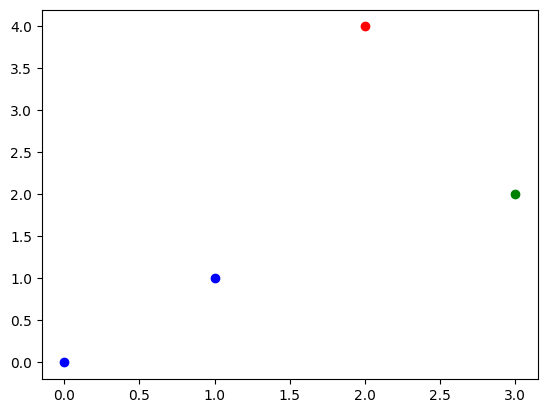

{'b': [(0.0, 0.0), (1.0, 1.0)], 'r': [(2.0, 4.0)], 'g': [(3.0, 2.0)]}


In [27]:
cluster_points(scattered_points)